## Data setup

Don't forget to download the Kaggle token from https://www.kaggle.com/settings

In [ ]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

!kaggle competitions download -c playground-series-s5e2
!mkdir -p data
!mv playground-series-s5e2.zip data/
%cd data
!unzip playground-series-s5e2.zip
!rm playground-series-s5e2.zip
!ls -lh
%cd ..

## Load data

In [1]:
import pandas as pd

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


## Exploratory Data Analysis

Missing Data

In [ ]:
missing_values_train = pd.DataFrame({
    'Column': train_data.columns,
    'Missing Train Values': train_data.isnull().sum().values,
    'Percentage of Missing Train Values': train_data.isnull().sum().values / len(train_data) * 100
})

missing_values_test = pd.DataFrame({
    'Column': test_data.columns,
    'Missing Test Values': test_data.isnull().sum().values,
    'Percentage of Missing Test Values': test_data.isnull().sum().values / len(test_data) * 100
})

merged_missing_values = pd.merge(missing_values_train, missing_values_test, on='Column', how='outer')
merged_missing_values

Duplicated Data

In [ ]:
train_data_duplicates = train_data.duplicated().sum()
test_data_duplicates = test_data.duplicated().sum()
print(f"Train data duplicates: {train_data_duplicates}")
print(f"Test data duplicates: {test_data_duplicates}")

Data Description

In [24]:
train_data.describe()

,id,Compartments,Weight Capacity (kg),Price
count,300000.000000,300000.000000,299862.000000,300000.000000
mean,149999.500000,5.443590,18.029994,81.411107
std,86602.684716,2.890766,6.966914,39.039340
min,0.000000,1.000000,5.000000,15.000000
25%,74999.750000,3.000000,12.097867,47.384620
50%,149999.500000,5.000000,18.068614,80.956120
75%,224999.250000,8.000000,24.002375,115.018160
max,299999.000000,10.000000,30.000000,150.000000


Distribution of Data

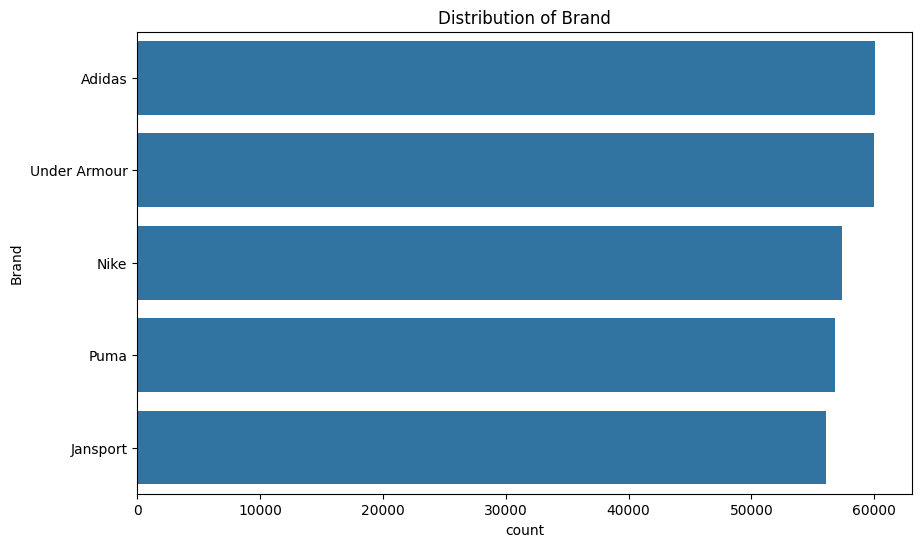

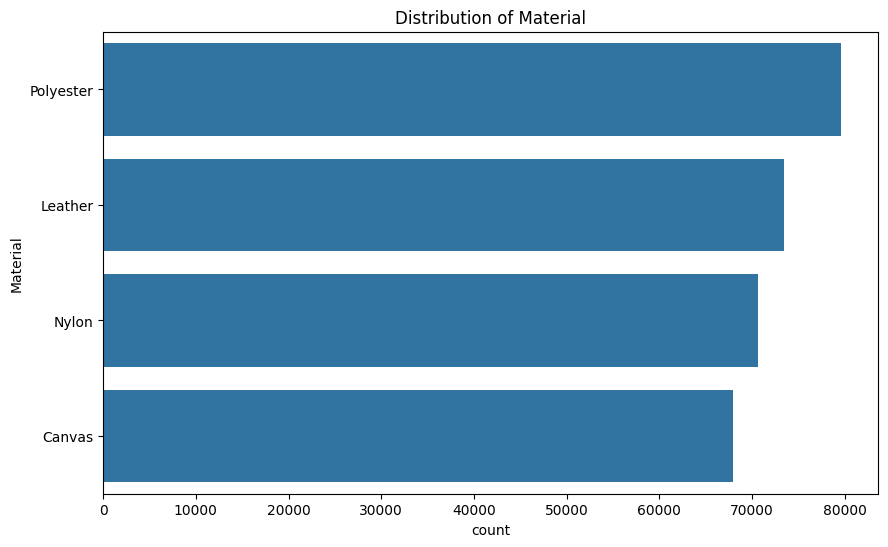

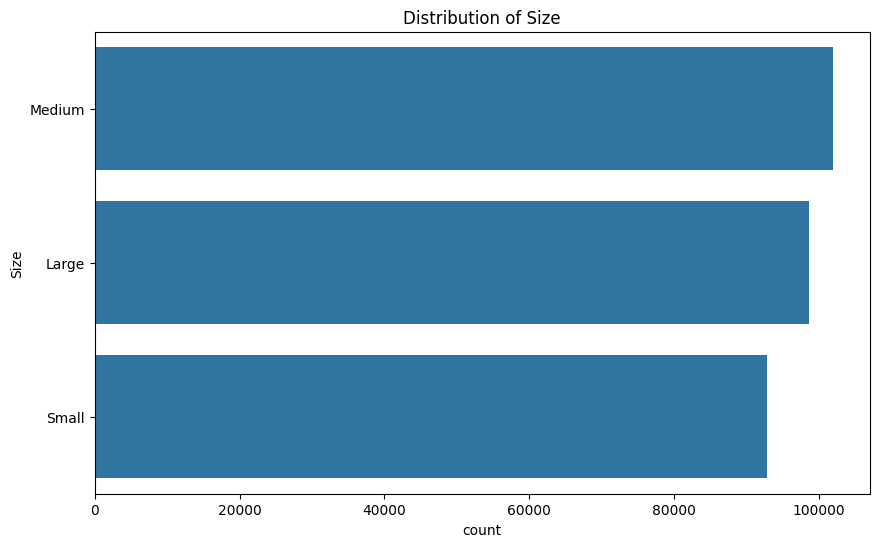

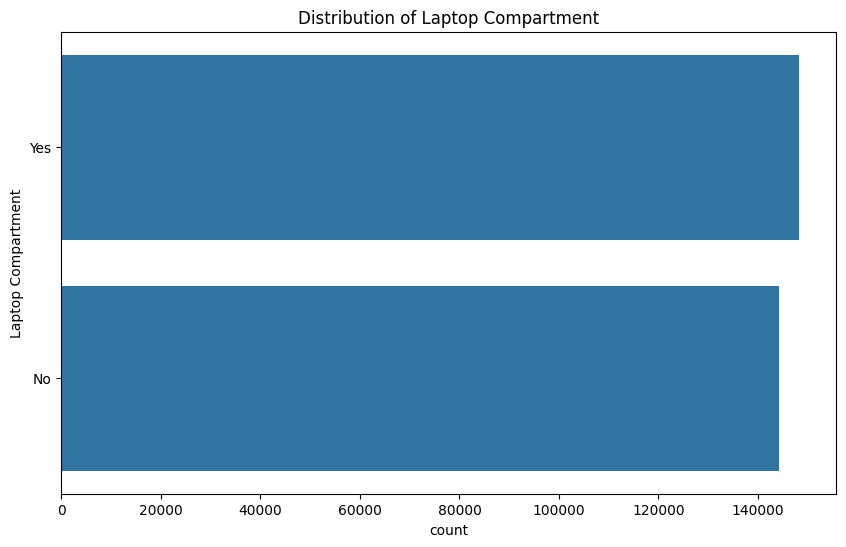

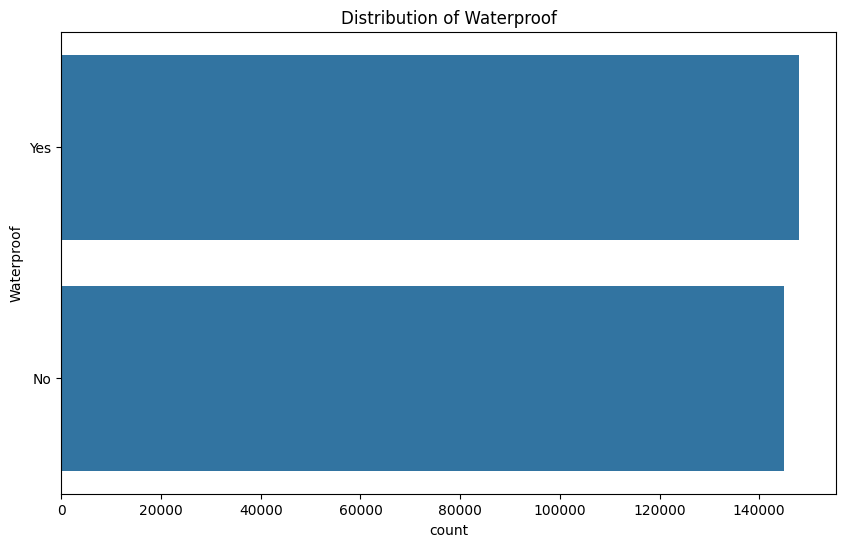

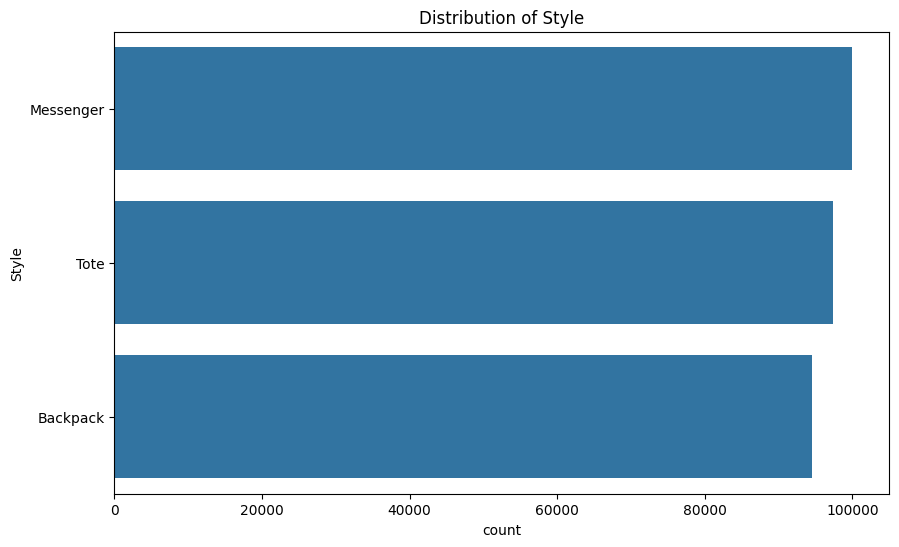

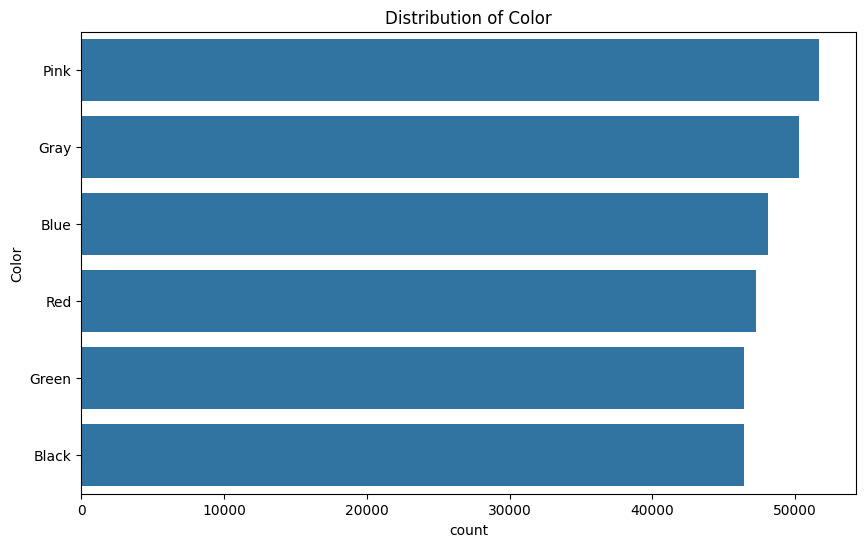

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def plot_text_columns(data, columns):
    for column in columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(data[column], order=data[column].value_counts().index)
        plt.title(f"Distribution of {column}")
        plt.show()
plot_text_columns(train_data, train_data.columns[train_data.dtypes == 'object'].tolist())


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['Compartments', 'Weight Capacity (kg)', 'Price']

df_numeric = train_data[numeric_cols].dropna()

sns.pairplot(df_numeric)


## Encode categorical features and define features and targets

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

train_data.dropna(inplace=True)
label_encoders = {}
for col in ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    label_encoders[col] = le

X = train_data.drop('Price', axis=1)
y = train_data['Price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

model = DecisionTreeRegressor(random_state=1, max_depth=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {mse**0.5:.2f}")



In [ ]:
from sklearn.tree import export_graphviz
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(100, 20))
plot_tree(model, filled=True, feature_names=X.columns, fontsize=10, max_depth=5)
plt.title("Decision Tree Visualization")
plt.show()
